In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D,Conv2DTranspose
from tensorflow.keras.layers import Input, concatenate
from keras.utils import plot_model
from google.colab import drive
from datetime import datetime

In [ ]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

SEED = 1234
tf.random.set_seed(SEED)  

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': 
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
apply_data_augmentation = False
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0,
                                            rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             rescale=1./255)
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255)

test_img_data_gen = ImageDataGenerator(rescale=1./255)
test_mask_data_gen = ImageDataGenerator()

In [ ]:
drive.mount('/content/gdrive')
cwd = '/content/gdrive/My Drive/Colab Notebooks'
dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')

img_h = 256
img_w = 256

training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=16, 
                                                       color_mode='rgb',
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       subset='training',
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=16,
                                                         color_mode='grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         subset='training',
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_dir = os.path.join(test_dir, 'images')
test_img_gen = test_img_data_gen.flow_from_directory(test_dir,
                                                     target_size=(img_h, img_w),
                                                     batch_size=16, 
                                                     class_mode=None, # Because we have no class subfolders in this case
                                                     shuffle=False,
                                                     interpolation='bilinear',
                                                     seed=SEED)


#not important but to avoid error
test_mask_gen = test_mask_data_gen.flow_from_directory(test_dir,
                                                       target_size=(img_h, img_w),
                                                       batch_size=16, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED)

test_gen = zip(test_img_gen, test_mask_gen)

Mounted at /content/gdrive
Found 7647 images belonging to 1 classes.
Found 7647 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


In [ ]:
def prepare_target(x_, y_):
    y_ = tf.cast(y_,tf.int32)
    return x_, y_

# Training+validation
dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                    output_types=(tf.float32, tf.float32),
                                    output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
dataset = dataset.map(prepare_target)

#seperate train and validation
train_size = int(.95*len(train_img_gen))
train_dataset = dataset.take(train_size)
train_dataset = train_dataset.repeat()
valid_dataset = dataset.skip(train_size)
valid_dataset = valid_dataset.repeat()

# Test
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen, 
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))
test_dataset = test_dataset.map(prepare_target)
test_dataset = test_dataset.repeat()


# U-Net

In [ ]:
inputs= Input((img_h, img_w, 3))
inputsf= tf.keras.layers.Lambda( lambda x: x/255)(inputs)

# encoder
c1= Conv2D(16, (3,3), activation='relu', padding='same')(inputsf)
c1= Dropout(0.1)(c1)
c1= Conv2D(16, (3,3), activation='relu', padding='same')(c1)
p1= MaxPooling2D((2,2))(c1)

c2= Conv2D(32, (3,3), activation='relu', padding='same')(p1)
c2= Dropout(0.2)(c2)
c2= Conv2D(32, (3,3), activation='relu', padding='same')(c2)
p2= MaxPooling2D((2,2))(c2)

c3= Conv2D(64, (3,3), activation='relu', padding='same')(p2)
c3= Dropout(0.2)(c3)
c3= Conv2D(64, (3,3), activation='relu', padding='same')(c3)
p3= MaxPooling2D((2,2))(c3)

c4= Conv2D(128, (3,3), activation='relu', padding='same')(p3)
c4= Dropout(0.2)(c4)
c4= Conv2D(128, (3,3), activation='relu', padding='same')(c4)
p4= MaxPooling2D((2,2))(c4)

c5= Conv2D(256, (3,3), activation='relu', padding='same')(p4)
c5= Dropout(0.3)(c5)
c5= Conv2D(256, (3,3), activation='relu', padding='same')(c5)
p4= MaxPooling2D((2,2))(c5)

# decoder
u6= Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6= concatenate([u6, c4])
c6= Conv2D(128, (3,3), activation='relu', padding='same')(u6)
c6= Dropout(0.2)(c6)
c6= Conv2D(128, (3,3), activation='relu', padding='same')(c6)

u7= Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7= concatenate([u7, c3])
c7= Conv2D(64, (3,3), activation='relu', padding='same')(u7)
c7= Dropout(0.2)(c7)
c7= Conv2D(64, (3,3), activation='relu', padding='same')(c7)

u8= Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8= concatenate([u8, c2])
c8= Conv2D(32, (3,3), activation='relu', padding='same')(u8)
c8= Dropout(0.1)(c8)
c8= Conv2D(32, (3,3), activation='relu', padding='same')(c8)

u9= Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9= concatenate([u9, c1])
c9= Conv2D(128, (3,3), activation='relu', padding='same')(u9)
c9= Dropout(0.1)(c9)
c9= Conv2D(128, (3,3), activation='relu', padding='same')(c9)

outputs= Conv2D(1, (1,1), activation='sigmoid')(c9)
model= Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

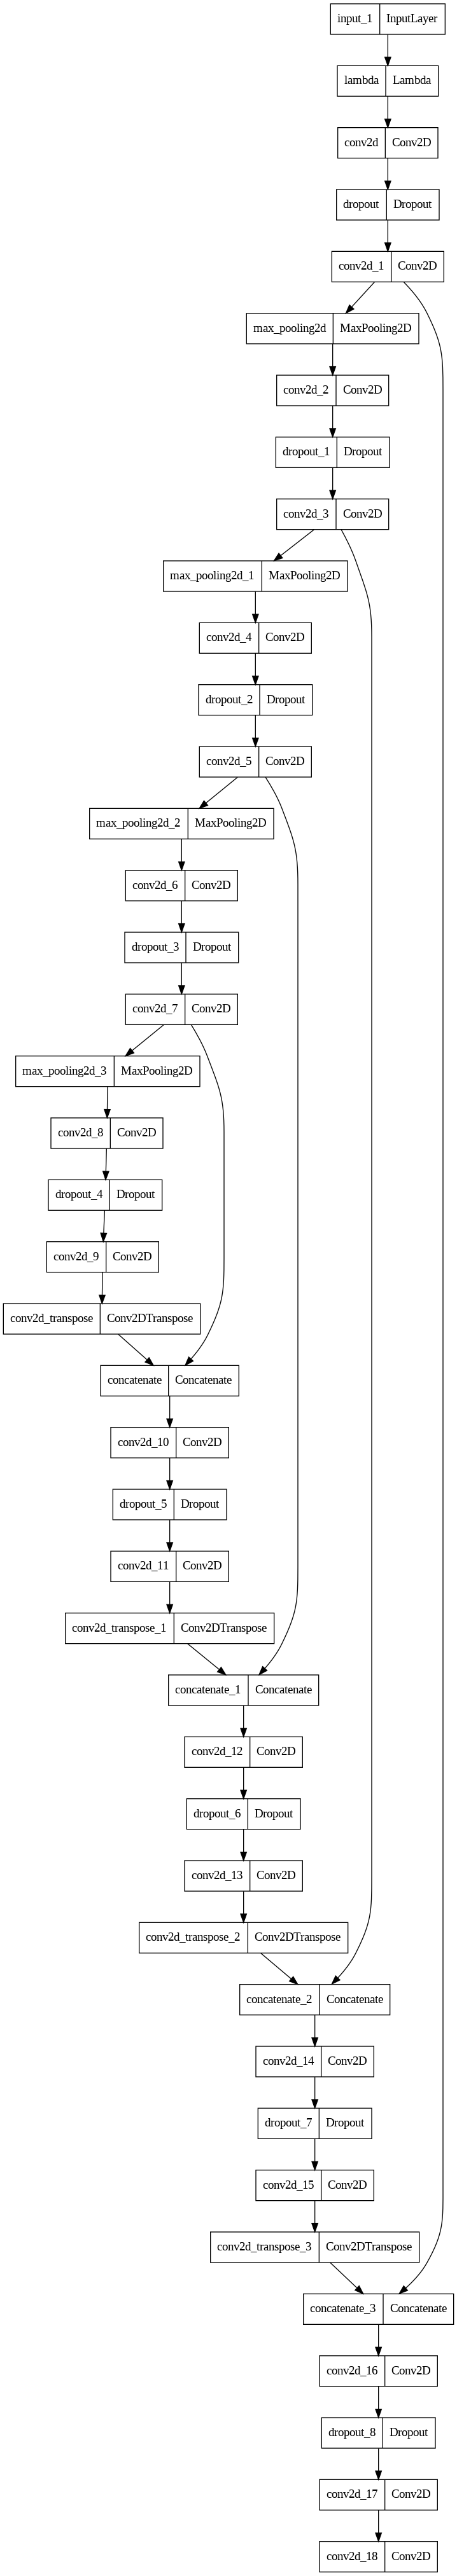

In [ ]:
plot_model(model)

In [ ]:
exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'SemanticSegmentation_UNet'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=3)
    callbacks.append(es_callback)

with tf.device('/device:GPU:0'):
  model.fit(x=train_dataset,
            epochs=30,  #### set repeat in training dataset
            steps_per_epoch= train_size,
            validation_data= valid_dataset,
            validation_steps= len(train_img_gen)-train_size,
            callbacks=callbacks)

Epoch 1/30
454/454 [==============================] - 1763s 4s/step - loss: 0.5733 - accuracy: 0.7135 - val_loss: 0.5501 - val_accuracy: 0.7344
Epoch 2/30
454/454 [==============================] - 209s 460ms/step - loss: 0.5465 - accuracy: 0.7317 - val_loss: 0.5500 - val_accuracy: 0.7277
Epoch 3/30
454/454 [==============================] - 196s 432ms/step - loss: 0.5328 - accuracy: 0.7413 - val_loss: 0.4912 - val_accuracy: 0.7734
Epoch 4/30
454/454 [==============================] - 205s 452ms/step - loss: 0.4834 - accuracy: 0.7782 - val_loss: 0.4522 - val_accuracy: 0.7950
Epoch 5/30
454/454 [==============================] - 205s 451ms/step - loss: 0.4443 - accuracy: 0.8019 - val_loss: 0.4199 - val_accuracy: 0.8148
Epoch 6/30
454/454 [==============================] - 196s 431ms/step - loss: 0.4187 - accuracy: 0.8156 - val_loss: 0.3912 - val_accuracy: 0.8277
Epoch 7/30
454/454 [==============================] - 205s 452ms/step - loss: 0.3966 - accuracy: 0.8274 - val_loss: 0.3781 - v

In [ ]:
# Just for exercise try to restore a model after training it
# !! Use this just when restoring model.. 
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
cwd = '/content/gdrive/My Drive'
restore_model = True
if restore_model:
    model = create_model(depth=4, #4
                         start_f=4, #4
                         num_classes=1, #3
                         dynamic_input_shape=True)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True) , 
                  metrics=['accuracy'])  # Needed for loading weights

    load_this = os.path.join( cwd, 'segmentation_experiments', 
                             'CNN_Dec16_20-07-25', 'ckpts', 'cp_100.ckpt')
    print('Loading: ' + load_this)
    model.load_weights(load_this)  # use this if you want to restore saved model
# ----------------------------------------

In [ ]:
pred_train= model.predict(train_dataset, verbose=1, 
                          steps= train_size)
pred_valid= model.predict(valid_dataset, verbose=1, 
                          steps= len(train_img_gen)-train_size)
pred_test= model.predict(test_dataset, verbose=1, 
                         steps= len(test_img_gen))

78/78 [==============================] - 9s 111ms/step
